Steps involved : Mount Google Drive and set dataset path, Imports, Load image pairs (side-by-side), Prepare datasets, Generator (mini U-Net), Discriminator (PatchGAN), Loss & Optimization parameters, Train and visualize.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


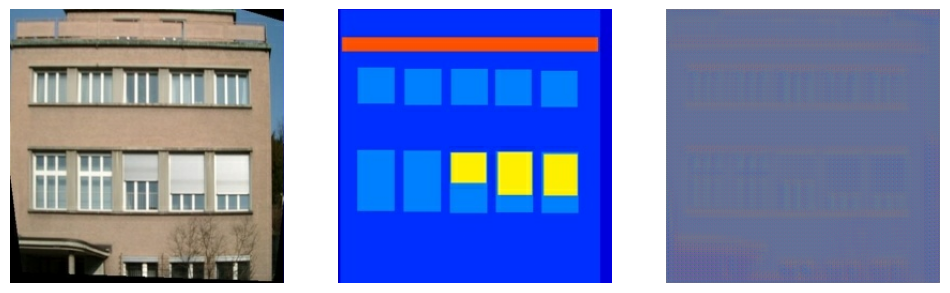

In [1]:

from google.colab import drive
drive.mount('/content/drive')

data_path = "/content/drive/MyDrive/facades/facades"

import tensorflow as tf
import matplotlib.pyplot as plt

def load_image_pair(image_path, img_size=(256, 256)):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img)
    w = tf.shape(img)[1] // 2
    input_img = tf.image.resize(img[:, :w], img_size)
    target_img = tf.image.resize(img[:, w:], img_size)
    input_img = (tf.cast(input_img, tf.float32) / 127.5) - 1
    target_img = (tf.cast(target_img, tf.float32) / 127.5) - 1
    return input_img, target_img


def build_dataset(folder, batch_size=1):
    files = tf.data.Dataset.list_files(f"{folder}/*.jpg", shuffle=True)
    return files.map(load_image_pair).cache().shuffle(100).batch(batch_size)

train = build_dataset(f"{data_path}/train")
test = build_dataset(f"{data_path}/val")

def Generator():
    inp = tf.keras.Input(shape=[256, 256, 3])
    x = tf.keras.layers.Conv2D(64, 4, strides=2, padding='same')(inp)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(128, 4, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2DTranspose(64, 4, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv2DTranspose(3, 4, strides=2, padding='same', activation='tanh')(x)
    return tf.keras.Model(inputs=inp, outputs=x)


def Discriminator():
    inp = tf.keras.Input(shape=[256, 256, 3])
    tar = tf.keras.Input(shape=[256, 256, 3])
    x = tf.keras.layers.Concatenate()([inp, tar])
    x = tf.keras.layers.Conv2D(64, 4, strides=2, padding='same')(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(128, 4, strides=2, padding='same')(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(1, 4, strides=1, padding='same')(x)
    return tf.keras.Model(inputs=[inp, tar], outputs=x)


loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)
LAMBDA = 100

def gen_loss(disc_out, gen_out, target):
    gan = loss_obj(tf.ones_like(disc_out), disc_out)
    l1 = tf.reduce_mean(tf.abs(target - gen_out))
    return gan + LAMBDA * l1

def disc_loss(real, fake):
    return loss_obj(tf.ones_like(real), real) + loss_obj(tf.zeros_like(fake), fake)

gen = Generator()
disc = Discriminator()
gen_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
disc_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

@tf.function
def train_step(inp, target):
    with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
        gen_out = gen(inp, training=True)
        disc_real = disc([inp, target], training=True)
        disc_fake = disc([inp, gen_out], training=True)
        g_loss = gen_loss(disc_fake, gen_out, target)
        d_loss = disc_loss(disc_real, disc_fake)
    gen_opt.apply_gradients(zip(g_tape.gradient(g_loss, gen.trainable_variables), gen.trainable_variables))
    disc_opt.apply_gradients(zip(d_tape.gradient(d_loss, disc.trainable_variables), disc.trainable_variables))


for i, (inp, tgt) in enumerate(train.take(100)):
    train_step(inp, tgt)


for inp, tgt in test.take(1):
    pred = gen(inp, training=False)[0]
    plt.figure(figsize=(12, 4))
    for i, img in enumerate([inp[0], tgt[0], pred]):
        plt.subplot(1, 3, i+1)
        plt.imshow((img + 1) / 2)
        plt.axis("off")
    plt.show()